In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import wavelet_transform as wt
import signal_processing as sp
from create_graph import create_graph
import scipy.sparse


/tmp/ipykernel_273164/4102537558.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%matplotlib inline

In [3]:
shapefile = gpd.read_file("data/LAYER_DISTRITO/sp.shp")
adj_matrix = create_graph(shapefile)
signal_1 = np.load("data/time_series/furto_celular_district.npy")
signal_2 = np.load("data/time_series/roubo_celular_district.npy")
signal_3 = np.load("data/time_series/wave_district.npy")
n_timestamps = signal_1.shape[1]

In [4]:
wav =  wt.WaveletTransform(
    adj_matrix,
    n_timestamps,
    graph_product="strong",
    n_filters=32,
    kernel="abspline",
    scaling_function=False,
    method="chebyshev",
    order_chebyshev=30,
)

In [5]:
coeffs_1 = wav.transform(signal_1)
coeffs_2 = wav.transform(signal_2)
coeffs_3 = wav.transform(signal_3)

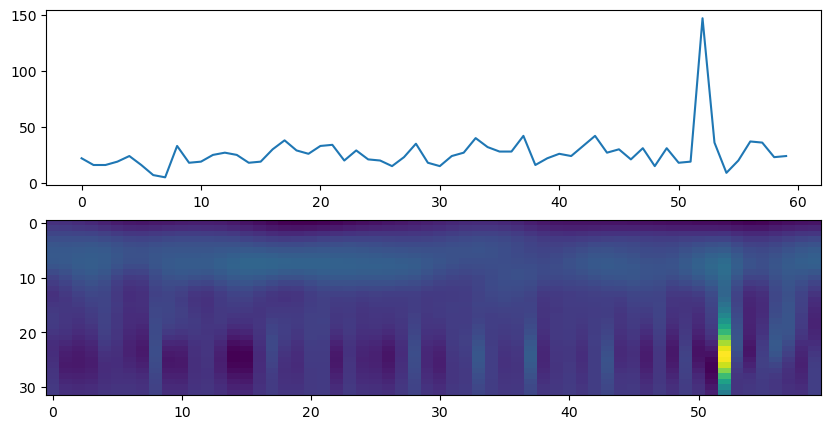

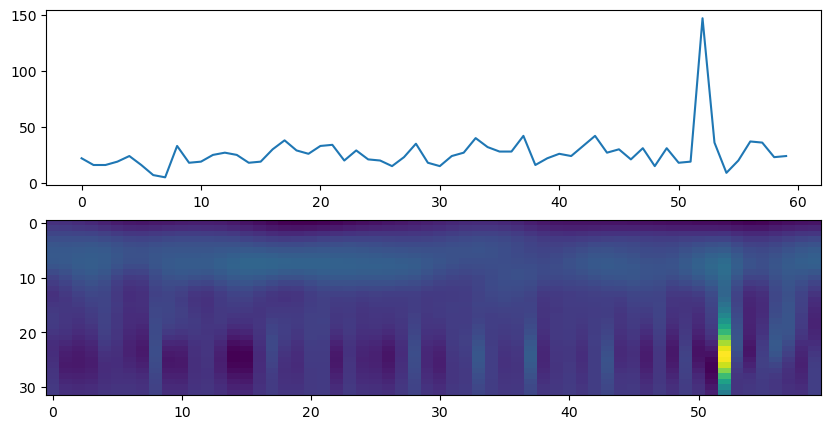

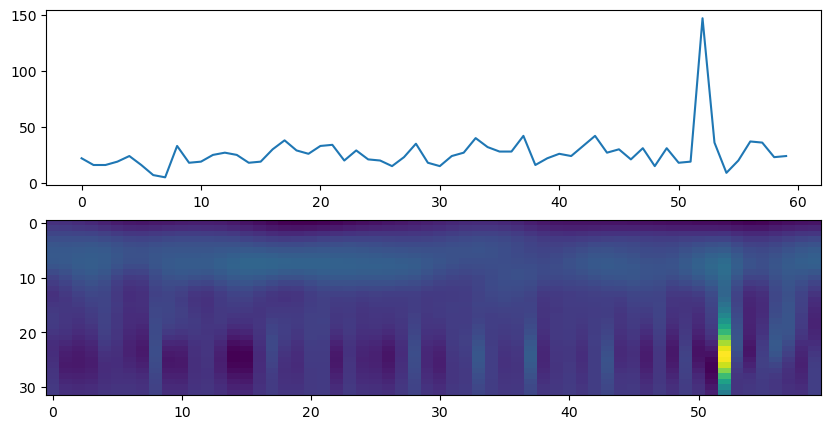

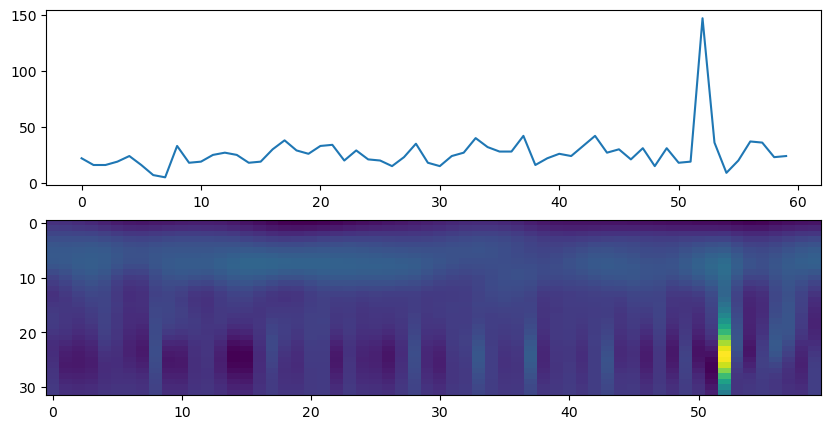

In [9]:
i = 0
fig = plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(signal_1[i])

plt.subplot(2, 1, 2)
plt.imshow(coeffs_1[i].T, aspect="auto", cmap="viridis")

plt.show()

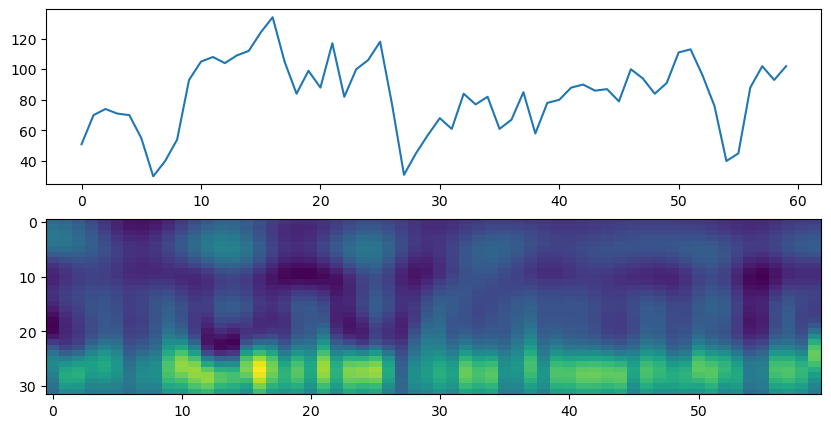

In [11]:
i = 10
fig = plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(signal_1[i])

plt.subplot(2, 1, 2)
plt.imshow(coeffs_1[i].T, aspect="auto", cmap="viridis")

plt.show()

In [6]:
def divide_frequencies(coeffs):
    scaled_coeffs = sp.get_scaled_coefficients(coeffs)
    n_f = scaled_coeffs.shape[-1]
    assert n_f % 4 == 0
    n_f = n_f // 4

    dom_freq = np.zeros((scaled_coeffs.shape[0], scaled_coeffs.shape[1], 4))
    for i in range(4):
        dom_freq[:, :, i] = np.mean(scaled_coeffs[:, :, i * n_f : (i + 1) * n_f], axis=-1)

    return dom_freq

dom_freq_1 = divide_frequencies(coeffs_1)
dom_freq_2 = divide_frequencies(coeffs_2)
dom_freq_3 = divide_frequencies(coeffs_3)

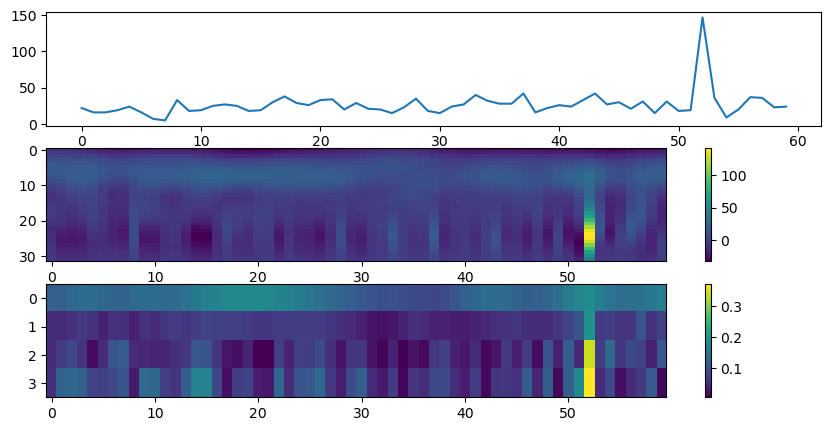

In [23]:
i = 0
fig = plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(signal_1[i])

plt.subplot(3, 1, 2)
plt.imshow(coeffs_1[i].T, aspect="auto", cmap="viridis")
plt.colorbar()

plt.subplot(3, 1, 3)
plt.imshow(dom_freq_1[i].T, aspect="auto", cmap="viridis")
plt.colorbar()

plt.show()

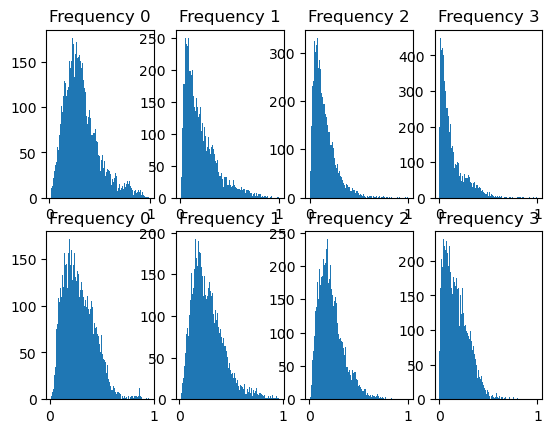

In [25]:
fig, axs = plt.subplots(nrows = 2, ncols = 4)

for i in range(4):
    axs[0, i].hist(dom_freq_1[:, :, i].flatten(), bins=100)
    axs[0, i].set_title(f"Frequency {i}")

    axs[1, i].hist(dom_freq_2[:, :, i].flatten(), bins=100)
    axs[1, i].set_title(f"Frequency {i}")

plt.show()

In [18]:
def get_high_freq(dom_freq, threshold = 0.6):
    high_freq = dom_freq > threshold
    high_freq = high_freq.sum(axis = 0)
    return high_freq

high_freq_1 = get_high_freq(dom_freq_1)
high_freq_2 = get_high_freq(dom_freq_2)
high_freq_3 = get_high_freq(dom_freq_3)

- **Sugestões:**
- Focar no centro de São Paulo
- Olhar as categorias de sinal de trânsito
- Talvez não seja necessário a resolução de 1m (que é pouco disponível)
- Modificar a rede de polígonos para a rede de ruas
- Começo de revisão de literatura

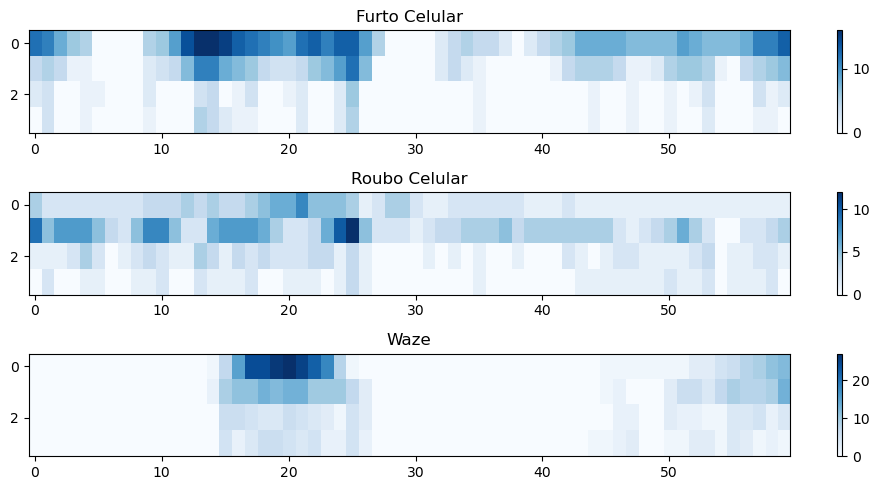

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(high_freq_1.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Furto Celular")

plt.subplot(3, 1, 2)
plt.imshow(high_freq_2.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Roubo Celular")


plt.subplot(3, 1, 3)
plt.imshow(high_freq_3.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Waze")

plt.tight_layout()

plt.show()


In [14]:
def test_other_approach(coeffs, threshold = 0.8):
    scaled_coeffs = sp.get_scaled_coefficients(coeffs)
    scaled_coeffs = scaled_coeffs[:, :, ::8]
    scaled_coeffs = scaled_coeffs > threshold
    scaled_coeffs = scaled_coeffs.sum(axis = 0)
    return scaled_coeffs

In [15]:
high_freq_1 = test_other_approach(coeffs_1)
high_freq_2 = test_other_approach(coeffs_2)
high_freq_3 = test_other_approach(coeffs_3)

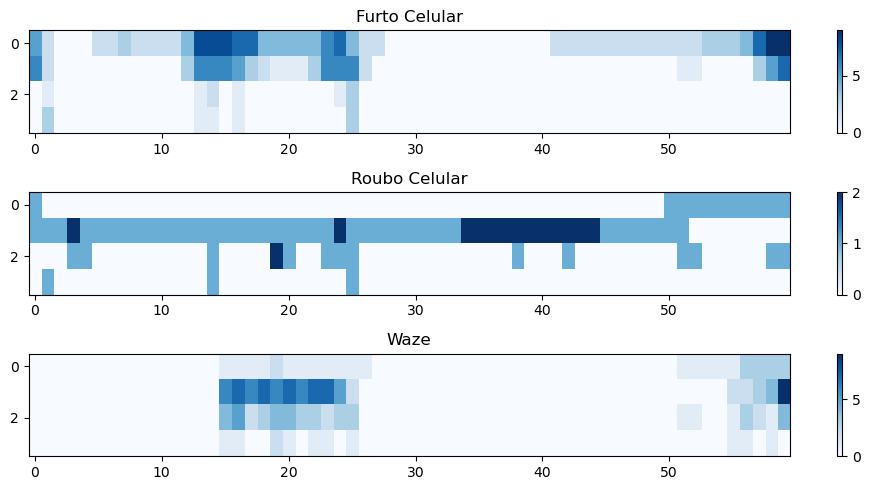

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(high_freq_1.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Furto Celular")

plt.subplot(3, 1, 2)
plt.imshow(high_freq_2.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Roubo Celular")

plt.subplot(3, 1, 3)
plt.imshow(high_freq_3.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Waze")

plt.tight_layout()

plt.show()


In [20]:
def get_signal_decomp(signal, adj_matrix):
    n_timestamps = signal.shape[1]

    wav =  wt.WaveletTransform(
        adj_matrix,
        n_timestamps,
        graph_product="strong",
        n_filters=32,
        kernel="abspline",
        scaling_function=False,
        method="chebyshev",
        order_chebyshev=30,
    )

    coeffs = wav.transform(signal)
    dom_freq = divide_frequencies(coeffs)
    high_freq = get_high_freq(dom_freq)
    return high_freq

In [21]:
signal_1 = np.load("data/time_series/furto_celular_district_daily.npy")
high_freq_1 = get_signal_decomp(signal_1, adj_matrix)

signal_2 = np.load("data/time_series/roubo_celular_district_daily.npy")
high_freq_2 = get_signal_decomp(signal_2, adj_matrix)

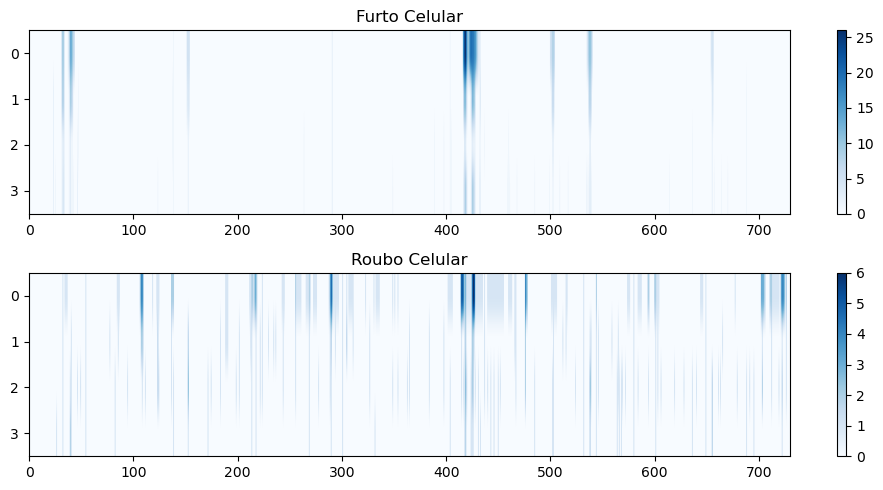

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.imshow(high_freq_1.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Furto Celular")

plt.subplot(2, 1, 2)
plt.imshow(high_freq_2.T, aspect="auto", cmap="Blues")
plt.colorbar()
plt.title("Roubo Celular")


plt.tight_layout()

plt.show()


## Save wavelet coefficients

### District

In [21]:
poly_division = "SpDistricts"
time_interval = "Month"
df = pd.read_csv(f"data/time_series/{poly_division}_{time_interval}.csv")
features = df.columns[2:]
adj_matrix = np.load(f"data/adj_matrix/{poly_division}.npy")
# transform dataframe into a numpy array with "id_poly" as the first dimension and "date" as the second, with the rest of the columns as the third dimension
signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)
df_res = df[["id_poly", "date"]].copy()

for k, feature in enumerate(features):
    signal = signal_multi[:, :, k]

    n_timestamps = signal_multi.shape[1]

    wav =  wt.WaveletTransform(
        adj_matrix,
        n_timestamps,
        graph_product="strong",
        n_filters=32,
        kernel="abspline",
        scaling_function=False,
        method="chebyshev",
        order_chebyshev=30,
    )
    coeffs = wav.transform(signal)
    coeffs = sp.get_scaled_coefficients(coeffs)
    # create column for coeffs in the df_res
    for i in range(coeffs.shape[-1]):
        df_res[f"{feature}_coeff_{i}"] = coeffs[:, :, i].flatten()
    df_res = df_res.copy()
    df_res[df_res.columns[2:]] = df_res[df_res.columns[2:]].astype(np.float32)
    df_res.to_csv(f"data/coeffs/{feature}_{poly_division}_{time_interval}.csv", index=False)
    df_res = df[["id_poly", "date"]].copy()

/tmp/ipykernel_273164/1861370491.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)
/home/giovani/Documents/AutoSatViewer/wavelet_code/signal_processing.py:145: RuntimeWarning: invalid value encountered in divide
  scaled_coefficients[:, i] = np.log(scaled_coefficients[:, i] + 1) / np.log(


In [22]:
poly_division = "SpCenterCensus10k"
time_interval = "Month"
df = pd.read_csv(f"data/time_series/{poly_division}_{time_interval}.csv")
features = df.columns[2:]
adj_matrix = scipy.sparse.load_npz(f"data/adj_matrix/{poly_division}.npz").toarray()
# transform dataframe into a numpy array with "id_poly" as the first dimension and "date" as the second, with the rest of the columns as the third dimension
signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)
df_res = df[["id_poly", "date"]].copy()

for k, feature in enumerate(features):
    signal = signal_multi[:, :, k]

    n_timestamps = signal_multi.shape[1]

    wav =  wt.WaveletTransform(
        adj_matrix,
        n_timestamps,
        graph_product="strong",
        n_filters=32,
        kernel="abspline",
        scaling_function=False,
        method="chebyshev",
        order_chebyshev=30,
    )
    coeffs = wav.transform(signal)
    coeffs = sp.get_scaled_coefficients(coeffs)
    # create column for coeffs in the df_res
    for i in range(coeffs.shape[-1]):
        df_res[f"{feature}_coeff_{i}"] = coeffs[:, :, i].flatten()
    df_res = df_res.copy()
    df_res[df_res.columns[2:]] = df_res[df_res.columns[2:]].astype(np.float32)
    df_res.to_csv(f"data/coeffs/{feature}_{poly_division}_{time_interval}.csv", index=False)
    df_res = df[["id_poly", "date"]].copy()


/tmp/ipykernel_273164/3026329325.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)


/home/giovani/Documents/AutoSatViewer/wavelet_code/signal_processing.py:145: RuntimeWarning: invalid value encountered in divide
  scaled_coefficients[:, i] = np.log(scaled_coefficients[:, i] + 1) / np.log(
